# Equity research demo
Steps in research process:
1. **pull_data.py**: functions to import raw data from WRDS API; datasets include CRSP for pricing, Compustat for fundamental data, IBES for analyst estimates, Thomson Reuters for 13F data
2. **create_feature_df.py**: functions to calculate stock characteristics (features) from input data, lag appropriately, and merge onto standardized dataframe; mostly replicating well-known academic papers + variations
3. **test_signals.py**: functions to create signals from features (rank features within a particular universe), perform analytics based on backtests, and output finalized models (collections of signals)
4. **optimize_portfolios.py**: functions to optimally combine a set of signals into a single ranking and to impose some basic portfolio construction constraints on that ranking to get final portfolio weights

This workbook:

1. Show feature dataframe (set of stock characteristics mostly replicated from well-known academic research + variations), and create some signals within universe of largest 3000 stocks
2. Demonstrate backtest functionality (time periods, comparisons to different signals, analysis with different asset pricing models, interactions with other features)
3. Import a particular model and examine different portfolio optimization methods applied to this model

In [1]:
from pull_data import *
from create_feature_df import get_features
from test_signals import get_universe,create_signal_df,backtest_signal,output_model,import_model
import os
import pickle
import pandas as pd
import numpy as np


/home/johnk1282/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
In /home/johnk1282/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/johnk1282/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/johnk1282/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
univ = get_universe(n_stocks=3000,
                  start_date='1980-01-01',
                  univ_path='',
                  univ_file='univ_3000.pkl')
univ.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1412998 entries, (10001.0, Timestamp('2011-04-01 00:00:00')) to (93436.0, Timestamp('2019-03-01 00:00:00'))
Data columns (total 15 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   me_lag    1412998 non-null  float64
 1   industry  1412998 non-null  float64
 2   retadj    1412998 non-null  float64
 3   retadj1   1403062 non-null  float64
 4   retadj2   1393248 non-null  float64
 5   retadj3   1383506 non-null  float64
 6   retadj4   1373810 non-null  float64
 7   retadj5   1364177 non-null  float64
 8   retadj6   1354561 non-null  float64
 9   retadj7   1344954 non-null  float64
 10  retadj8   1335307 non-null  float64
 11  retadj9   1325687 non-null  float64
 12  retadj10  1316052 non-null  float64
 13  retadj11  1306432 non-null  float64
 14  retadj12  1296834 non-null  float64
dtypes: float64(15)
memory usage: 167.9 MB


In [3]:
univ.head()

me_lag  industry    retadj   retadj1   retadj2  \
permno  date                                                            
10001.0 2011-04-01  91.892816      30.0 -0.038789  0.028050  0.008261   
        2011-05-01  91.535726      30.0  0.028050  0.008261 -0.028139   
        2011-06-01  93.736500      30.0  0.008261 -0.028139 -0.013864   
        2011-07-01  94.144052      30.0 -0.028139 -0.013864  0.005009   
        2011-08-01  91.128182      30.0 -0.013864  0.005009  0.005005   

                     retadj3   retadj4   retadj5   retadj6   retadj7  \
permno  date                                                           
10001.0 2011-04-01 -0.028139 -0.013864  0.005009  0.005005 -0.005000   
        2011-05-01 -0.013864  0.005009  0.005005 -0.005000  0.051835   
        2011-06-01  0.005009  0.005005 -0.005000  0.051835 -0.019702   
        2011-07-01  0.005005 -0.005000  0.051835 -0.019702  0.005005   
        2011-08-01 -0.005000  0.051835 -0.019702  0.005005  0.048760   

                     retadj8   retadj9  retadj10  retadj11  retadj12  
permno  date                                                          
10001.0 2011-04-01  0.051835 -0.019702  0.005005  0.048760 -0.015000  
        2011-05-01 -0.019702  0.005005  0.048760 -0.015000 -0.084361  
        2011-06-01  0.005005  0.048760 -0.015000 -0.084361 -0.027325  
        2011-07-01  0.048760 -0.015000 -0.084361 -0.027325  0.009406  
        2011-08-01 -0.015000 -0.084361 -0.027325  0.009406 -0.012315

In [4]:
feat = get_features(overwrite=False,
                  feat_path='',
                  feat_file='features.pkl')
feat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4386004 entries, (10000.0, Timestamp('1986-02-01 00:00:00')) to (93436.0, Timestamp('2019-03-01 00:00:00'))
Columns: 145 entries, mean_5 to ret_unexpl_5
dtypes: float64(143), object(2)
memory usage: 4.8+ GB


In [5]:
feat.head()

mean_5  mean_10  mean_22  mean_198  mean_252  mean_756  \
permno  date                                                                 
10000.0 1986-02-01     NaN      NaN      NaN       NaN       NaN       NaN   
        1986-03-01     NaN      NaN      NaN       NaN       NaN       NaN   
        1986-04-01     NaN      NaN      NaN       NaN       NaN       NaN   
        1986-05-01     NaN      NaN      NaN       NaN       NaN       NaN   
        1986-06-01     NaN      NaN      NaN       NaN       NaN       NaN   

                    std_22  std_252  volume_5  volume_5_shrout  ...  pe0  pe1  \
permno  date                                                    ...             
10000.0 1986-02-01     NaN      NaN       NaN              NaN  ...  NaN  NaN   
        1986-03-01     NaN      NaN       NaN              NaN  ...  NaN  NaN   
        1986-04-01     NaN      NaN       NaN              NaN  ...  NaN  NaN   
        1986-05-01     NaN      NaN       NaN              NaN  ...  NaN  NaN   
        1986-06-01     NaN      NaN       NaN              NaN  ...  NaN  NaN   

                    pe2  pe3  pe4  pe5  ltg  ret_unexpl_22  ret_unexpl_10  \
permno  date                                                                
10000.0 1986-02-01  NaN  NaN  NaN  NaN  NaN            NaN            NaN   
        1986-03-01  NaN  NaN  NaN  NaN  NaN            NaN            NaN   
        1986-04-01  NaN  NaN  NaN  NaN  NaN            NaN            NaN   
        1986-05-01  NaN  NaN  NaN  NaN  NaN            NaN            NaN   
        1986-06-01  NaN  NaN  NaN  NaN  NaN            NaN            NaN   

                    ret_unexpl_5  
permno  date                      
10000.0 1986-02-01           NaN  
        1986-03-01           NaN  
        1986-04-01           NaN  
        1986-05-01           NaN  
        1986-06-01           NaN  

[5 rows x 145 columns]

In [6]:
feat.columns.values

array(['mean_5', 'mean_10', 'mean_22', 'mean_198', 'mean_252', 'mean_756',
       'std_22', 'std_252', 'volume_5', 'volume_5_shrout', 'stdvolume_22',
       'bidask_5', 'mve', 'corr_sp_22', 'corr_sp_252', 'corr_sp_756',
       'beta_sp_22', 'beta_sp_252', 'beta_sp_756', 'beta_sp_22_sq',
       'beta_sp_252_sq', 'beta_sp_756_sq', 'shrout_pct', 'e_std_22',
       'e_std_252', 'be_growth', 'asset_growth', 'inv', 'inv2',
       'sales_momentum', 'eps_momentum', 'prof_momentum',
       'prof2_momentum', 'cf_momentum', 'cf2_momentum', 'sales_growth',
       'eps_growth', 'prof_growth', 'prof2_growth', 'cf_growth',
       'cf2_growth', 'sales_std', 'eps_std', 'prof_std', 'prof2_std',
       'cf_std', 'cf2_std', 'sales_asset', 'eps_asset', 'prof_asset',
       'prof2_asset', 'cf_asset', 'cf2_asset', 'acc_asset', 'acc2_asset',
       'td_asset', 'sales_be', 'eps_be', 'prof_be', 'prof2_be', 'cf_be',
       'cf2_be', 'acc_be', 'acc2_be', 'td_be', 'chdebt_asset', 'chdebt_z',
       'chdebt_growth'

In [7]:
#examples of signals (some ff factors + momentum "improved")
value = {
    'signal_name':'value',
    'features':['be_me','sales_ev','prof_ev','cf_be'],
    'weights':[1,1,1,1],
    'industry_adjust':True
}
profitability = {
    'signal_name':'profitability',
    'features':['prof_asset','cf_asset','sales_asset'],
    'weights':[1,1,1],
    'industry_adjust':True
}
fmomentum = {
    'signal_name':'fmomentum',
    'features':['momentum_earn_3','momentum_idio_5','eps_momentum','cf_momentum'],
    'weights':[1,1,1,1],
    'industry_adjust':False
}

In [8]:
#model is just a list of signals
model_improved_ff = [value,profitability,fmomentum]
output_model(univ,feat,model_improved_ff,'improved_ff_3000',overwrite=False)

model improved_ff_3000 already output; import with import_model


In [9]:
#fl = ['ret_unexpl_22','ret_unexpl_10','ret_unexpl_5','bidask_5','volume_5','stdvolume_22']
#fl = ['sales_momentum_asof', 'prof_momentum_asof','prof2_momentum_asof', 'cf2_momentum_asof']+['sue','surprise_z']
#fl = ['chdebt_asset_asof', 'chdebt_z_asof','chdebt_growth_asof']
#fl = ['pe0', 'pe1','pe2','pe3', 'pe4','pe5','ltg']
#fl = ['beta_sp_22', 'beta_sp_252', 'beta_sp_756', 'beta_sp_22_sq','beta_sp_252_sq', 'beta_sp_756_sq']
#model = [{'signal_name':x,'features':[x],'weights':[1],'industry_adjust':False} for x in fl]
#f = fl[0]
#signals_to_compare = [x for x in fl if x != f]

feature_to_test = 'cf2_momentum_asof'
features_to_compare = ['sales_momentum_asof', 'prof_momentum_asof','prof2_momentum_asof','sue','surprise_z']
feature_to_interact = 'mve'

all_features = list(set([feature_to_test]+features_to_compare+[feature_to_interact]))
model = [{'signal_name':x,'features':[x],'weights':[1],'industry_adjust':False} for x in all_features]

In [10]:
df_sig = univ.pipe(create_signal_df,feat,model)

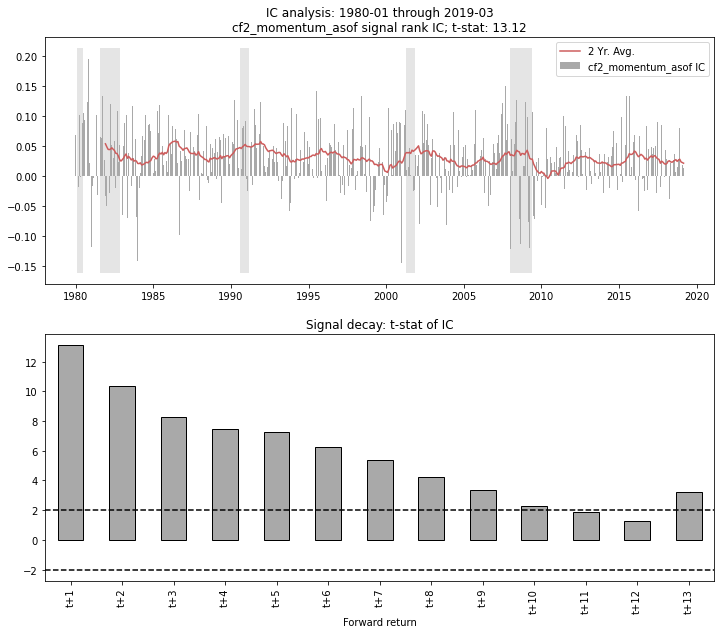

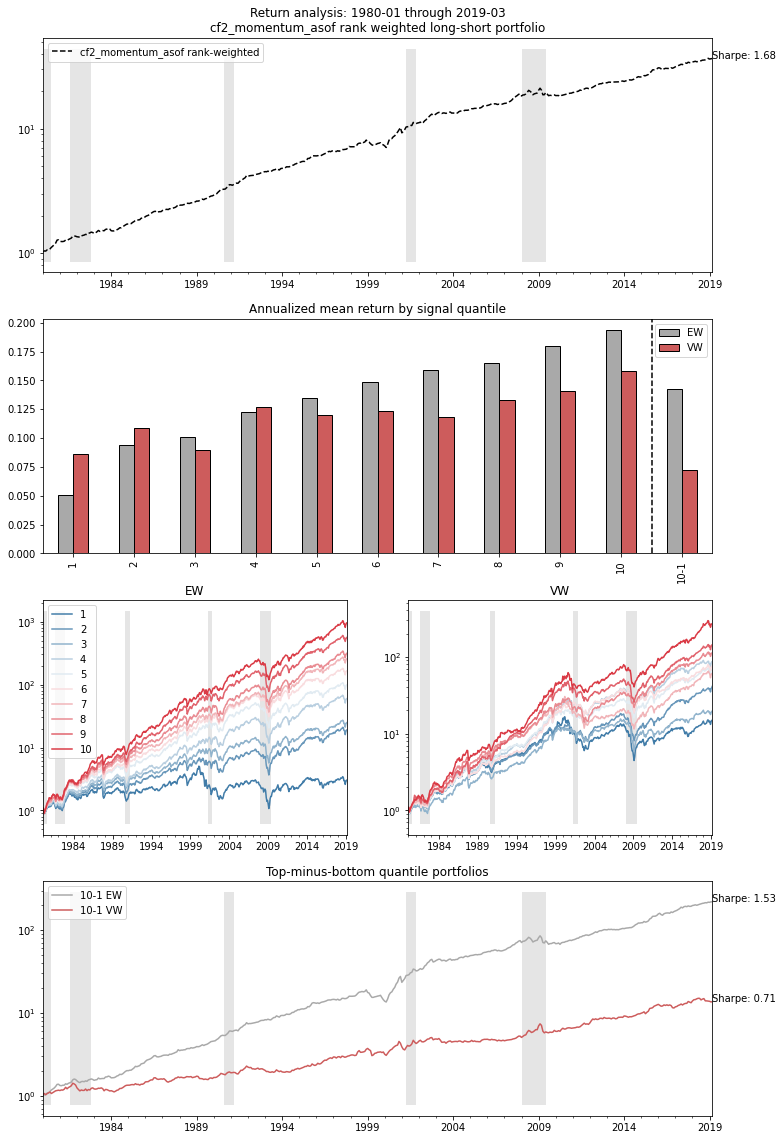

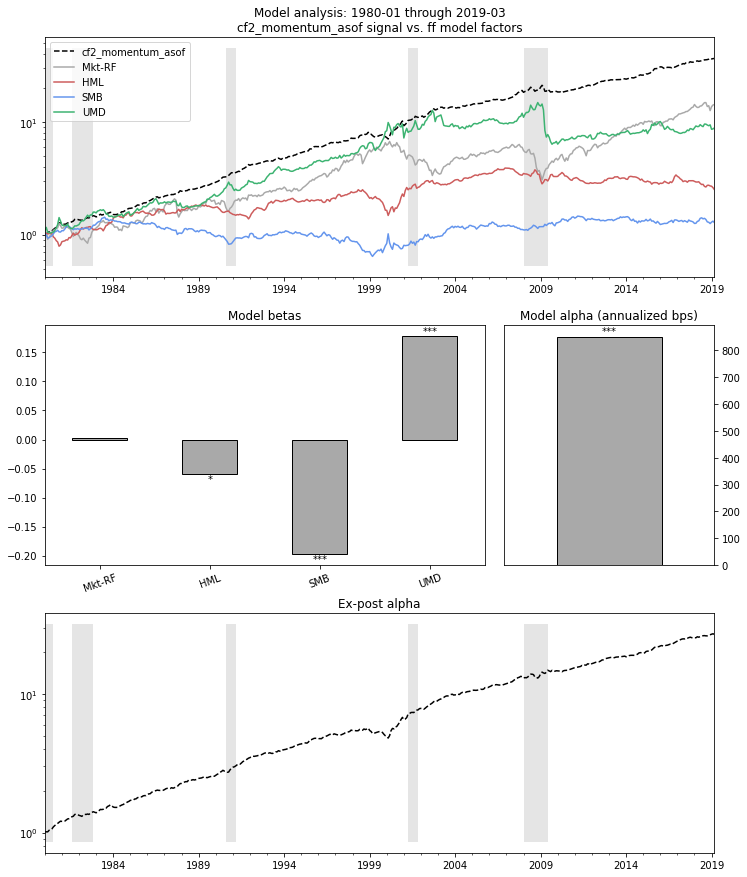

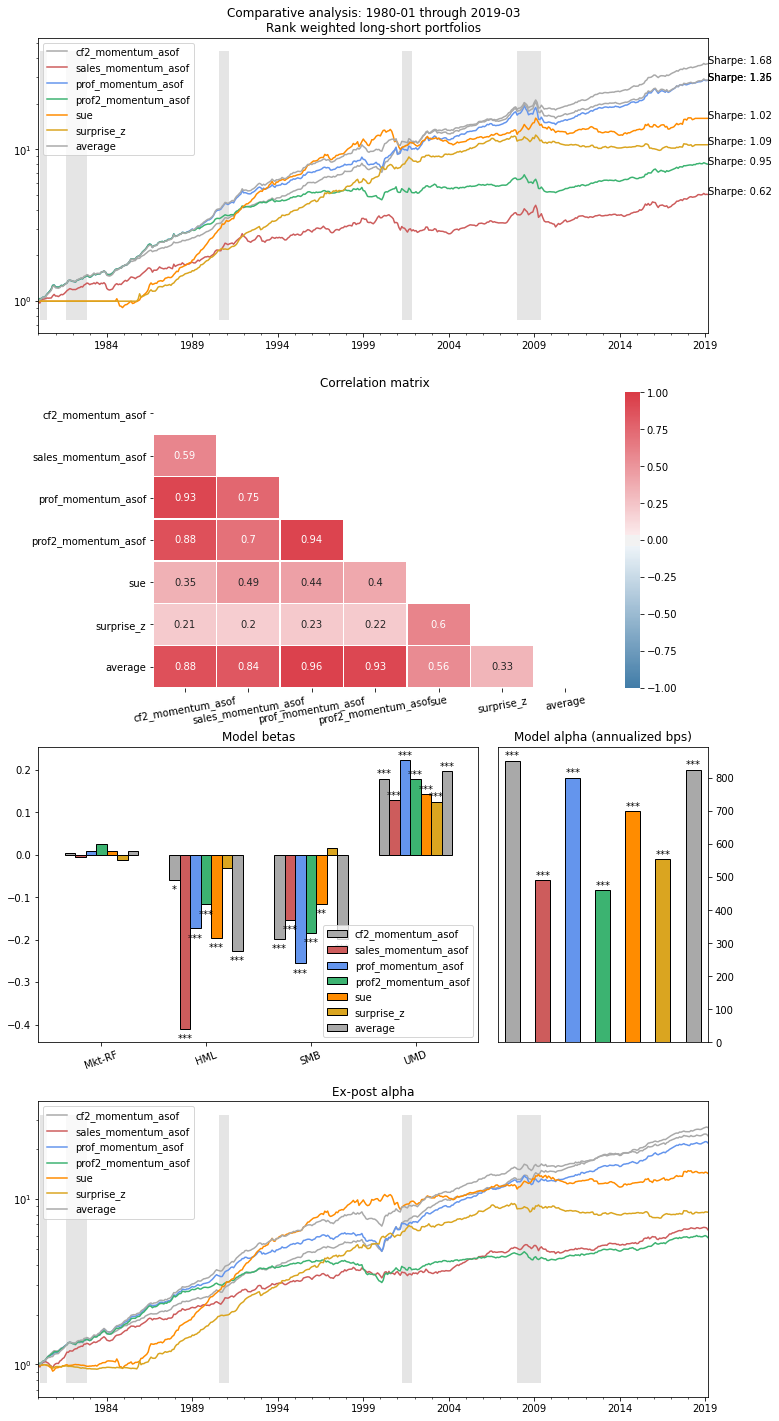

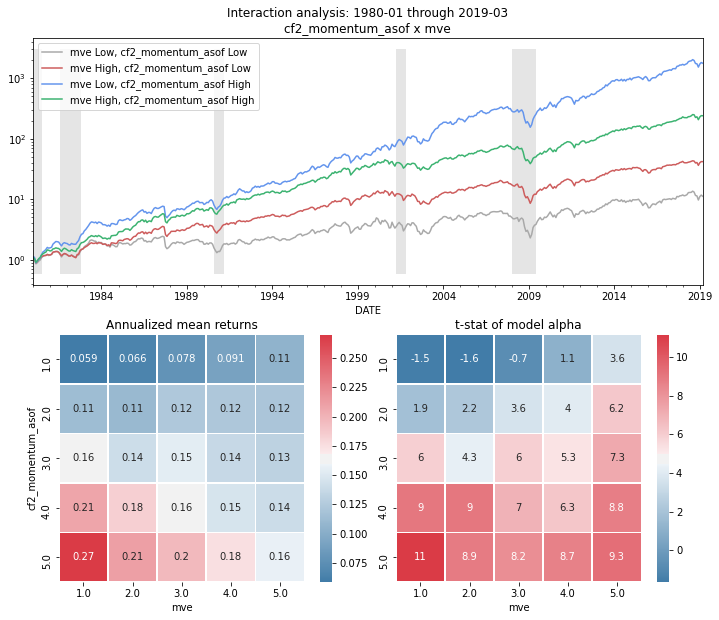

In [11]:
backtest_signal(df_sig,feature_to_test,
                start_date=None,
                end_date=None, #full period 
                ic_analysis=True,
                return_analysis=True,
                model_analysis=True,
                comparative_analysis=True,
                interaction_analysis=True,
                quantiles=10,
                signals_to_compare=features_to_compare,
                signal_to_interact=feature_to_interact,
                model_name='ff')

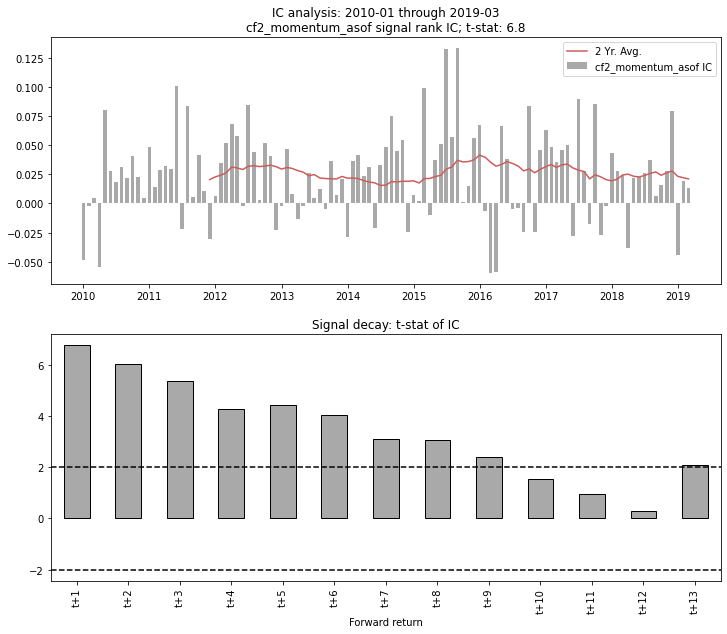

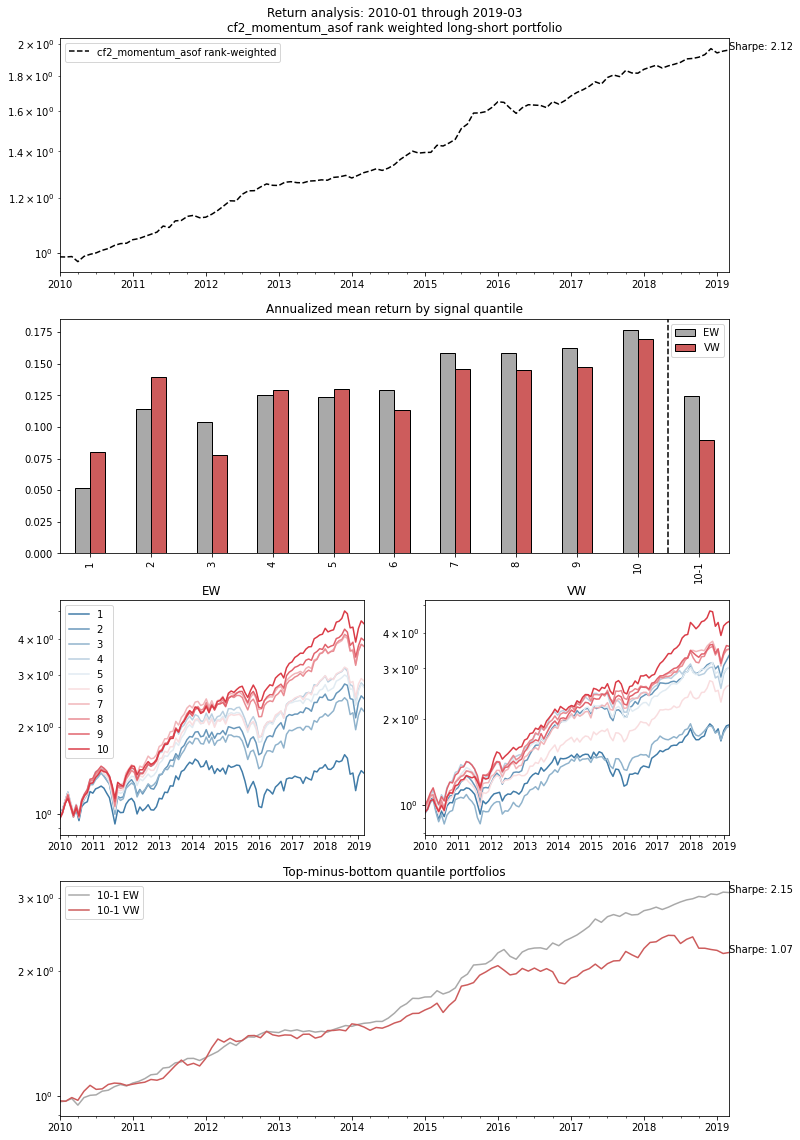

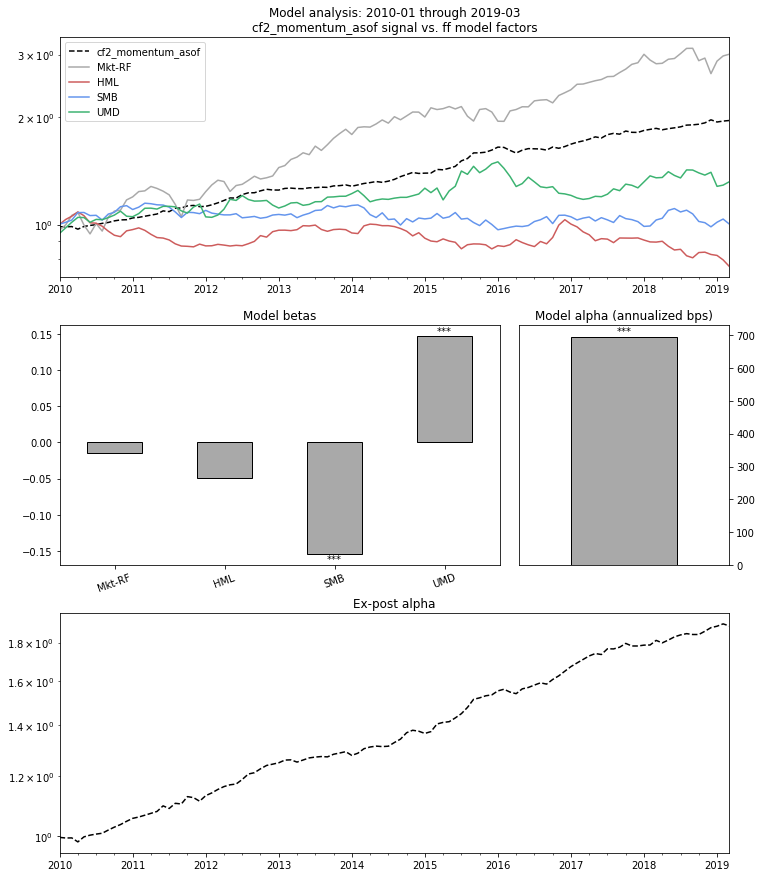

In [12]:
backtest_signal(df_sig,feature_to_test,
                start_date='2010-01-01', #more recent period
                end_date=None,
                ic_analysis=True,
                return_analysis=True,
                model_analysis=True,
                comparative_analysis=False,
                interaction_analysis=False,
                quantiles=10,
                signals_to_compare=[],
                signal_to_interact='',
                model_name='ff')


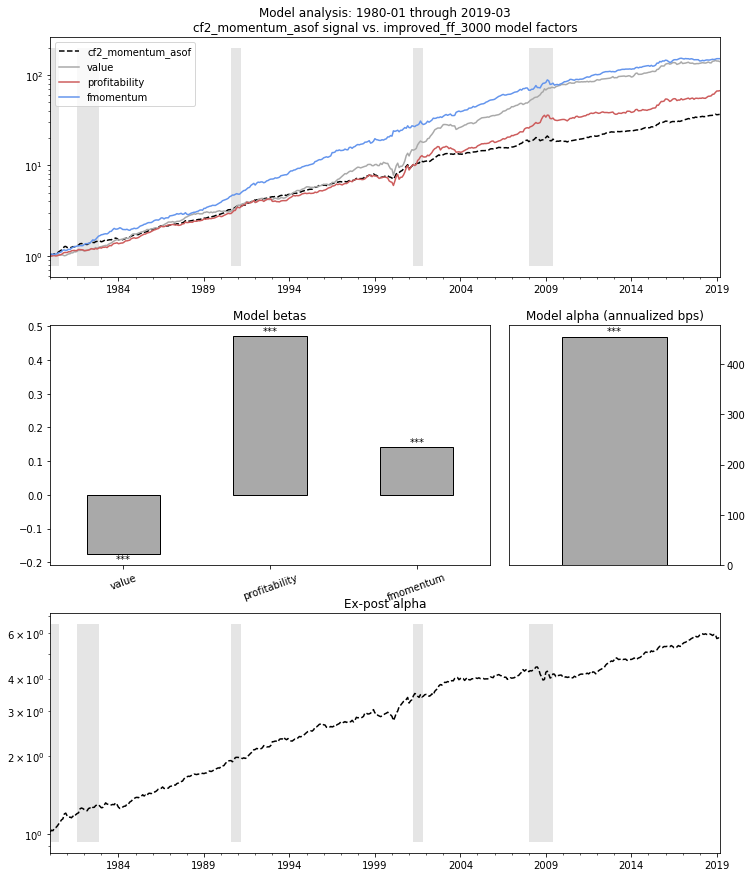

In [16]:
backtest_signal(df_sig,feature_to_test,
                start_date=None,
                end_date=None,
                ic_analysis=False,
                return_analysis=False,
                model_analysis=True,
                comparative_analysis=False,
                interaction_analysis=False,
                quantiles=10,
                signals_to_compare=features_to_compare,
                signal_to_interact='',
                model_name='improved_ff_3000')


In [14]:
univ_500 = get_universe(n_stocks=500,
                  start_date='1980-01-01',
                  univ_path='',
                  univ_file='univ_500.pkl')
df_sig_500 = univ_500.pipe(create_signal_df,feat,model)

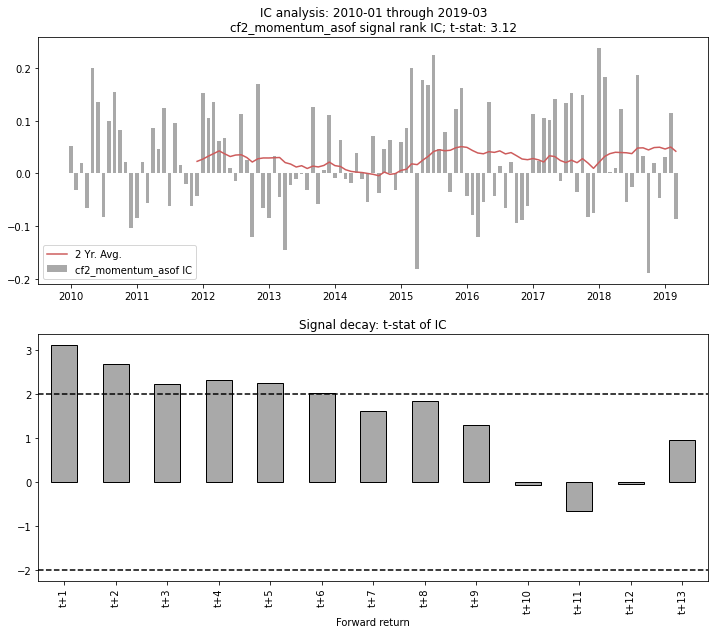

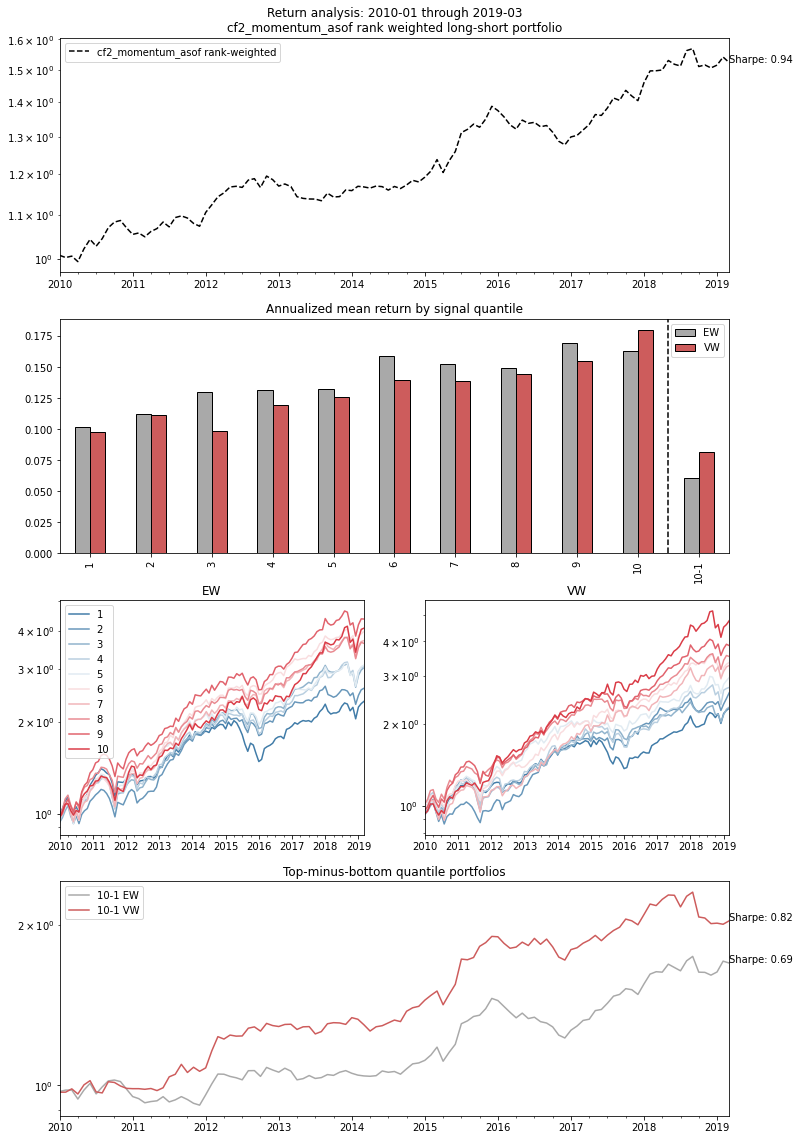

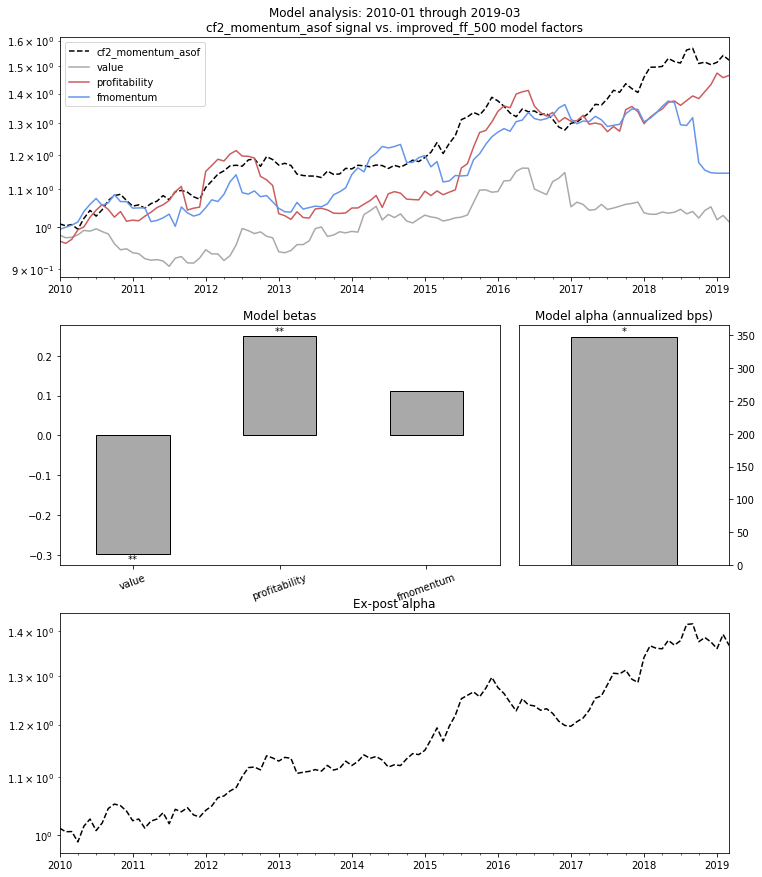

In [15]:
backtest_signal(df_sig_500,feature_to_test,
                start_date='2010-01-01',
                end_date=None,
                ic_analysis=True,
                return_analysis=True,
                model_analysis=True,
                comparative_analysis=False,
                interaction_analysis=False,
                quantiles=10,
                signals_to_compare=features_to_compare,
                signal_to_interact=feature_to_interact,
                model_name='improved_ff_500')